<a href="https://colab.research.google.com/github/mariaberardi/SVM_example/blob/main/Classification_model_for_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a ML classification model for cancer detection in cell samples

The task at hand is to use a dataset of human cell records to build and train a model that can classify samples as either malignant or benign. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

We use a publicly available dataset from the UCI Machine Learning Repository. 

In [2]:
#load the dataset
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv"

In [7]:
df = pd.read_csv(url)
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [8]:
df.describe

<bound method NDFrame.describe of           ID  Clump  UnifSize  UnifShape  MargAdh  SingEpiSize BareNuc  \
0    1000025      5         1          1        1            2       1   
1    1002945      5         4          4        5            7      10   
2    1015425      3         1          1        1            2       2   
3    1016277      6         8          8        1            3       4   
4    1017023      4         1          1        3            2       1   
..       ...    ...       ...        ...      ...          ...     ...   
694   776715      3         1          1        1            3       2   
695   841769      2         1          1        1            2       1   
696   888820      5        10         10        3            7       3   
697   897471      4         8          6        4            3       4   
698   897471      4         8          8        5            4       5   

     BlandChrom  NormNucl  Mit  Class  
0             3         1    1      2

In [14]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [16]:
#making sure all numerical values are treated as such
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

The columns contain the following information: 

*   ID is the patient ID
*   All columns from Clump to Mit describe the characteristics of the cell samples from the patients. They contain values from 1 to 10. 1 is the closest to benign, 10 the closest to cancerous. 
* The Class column gives the diagnosis obtained by separate medical procedures. It contains the value 2 for benign and 4 for malignant.

We start with some visualizations to analyze the problem.  

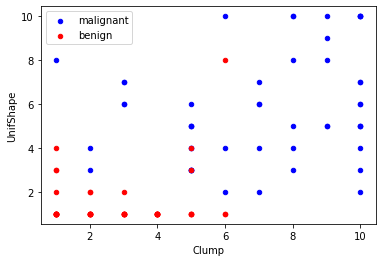

In [17]:
ax = df[df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifShape', color='Blue', label='malignant');
df[df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifShape', color='Red', label='benign', ax=ax);
plt.show()

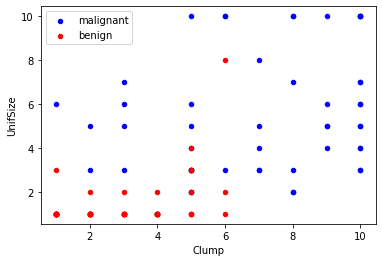

In [19]:
ax = df[df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Blue', label='malignant');
df[df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Red', label='benign', ax=ax);
plt.show()

Preliminary analysis shows that SVM might allow us to separate the two groups more effectively than regression. 

In [21]:
characteristics = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(characteristics) #array containing Clump to Mit columns data from df
X[0:10]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1],
       [ 8, 10, 10,  8,  7, 10,  9,  7,  1],
       [ 1,  1,  1,  1,  2, 10,  3,  1,  1],
       [ 2,  1,  2,  1,  2,  1,  3,  1,  1],
       [ 2,  1,  1,  1,  2,  1,  1,  1,  5],
       [ 4,  2,  1,  1,  2,  1,  2,  1,  1]])

In [23]:
#array of Class to predict
df['Class'] = df['Class'].astype('int')
Y = np.asarray(df['Class'])
Y [0:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([2, 2, 2, 2, 2, 4, 2, 2, 2, 2])

In [25]:
#split dataset into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25)

In [27]:
#fit the SVM model
from sklearn import svm
cl = svm.SVC(kernel='rbf') #We try using the rbf kernel. We will later use a linear kernel and compare results
cl.fit(X_train, Y_train) 

SVC()

In [28]:
#predict a value y using the model
y = cl.predict(X_test)
y [0:10]

array([2, 2, 2, 2, 2, 2, 4, 2, 2, 2])

In [29]:
#Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [30]:
#Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  print('Confusion matrix, without normalization')
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.99      0.99      0.99       104
           4       0.99      0.99      0.99        67

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Confusion matrix, without normalization
[[103   1]
 [  1  66]]


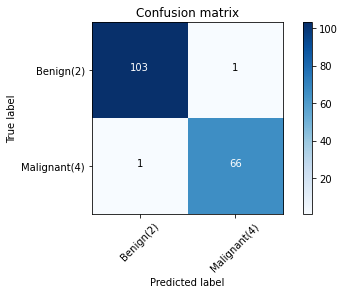

In [31]:
# Compute confusion matrix
cn_matrix = confusion_matrix(Y_test, y, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(Y_test, y))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cn_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

This first model built using the default kernel provided in sklearn only misclassified two samples. Let us try and build a model using a linear kernel, and then compare the performance. 

In [32]:
#fit the new SVM model
from sklearn import svm
cl2 = svm.SVC(kernel='linear') #this time we use a linear kernel
cl2.fit(X_train, Y_train) 

SVC(kernel='linear')

In [33]:
y2 = cl2.predict(X_test)

              precision    recall  f1-score   support

           2       0.98      0.99      0.99       104
           4       0.98      0.97      0.98        67

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Confusion matrix, without normalization
[[103   1]
 [  1  66]]


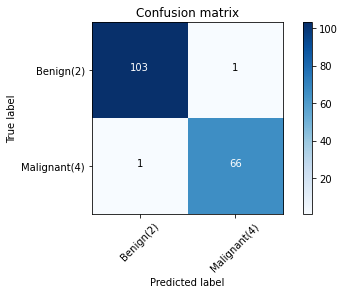

In [35]:
#Confusion matrix for the second model
cn_matrix2 = confusion_matrix(Y_test, y2, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(Y_test, y2))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cn_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

We get comparable results (the dataset used in this practice isn't very large). Let us compare some numerics as well. 

In [41]:
from sklearn.metrics import jaccard_score
print("The jaccard index for the first model is", jaccard_score(Y_test, y,pos_label=2))
print("The jaccard index for the second model is", jaccard_score(Y_test, y2,pos_label=2))

The jaccard index for the first model is 0.9809523809523809
The jaccard index for the second model is 0.9716981132075472


In [42]:
from sklearn.metrics import f1_score
print("The f_1 score for the first model is", f1_score(Y_test, y, average='weighted')) 
print("The f_1 score for the second model is", f1_score(Y_test, y2, average='weighted')) 

The f_1 score for the first model is 0.9883040935672515
The f_1 score for the second model is 0.9824321569473925
